<a href="https://colab.research.google.com/github/RusAl84/IntroML/blob/master/2_9_%D0%90%D1%83%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пример аугментации данных для классификации изображений.

# Классификация кошек и собак с аугментацией данных

Давайте посмотрим, как аугментация влияет на работу моделей, попробуем различить кошек и собак с и без аугментации.

In [ ]:
import tensorflow as tf # для работы с нейронными сетями
from tensorflow.keras.preprocessing.image import ImageDataGenerator # генератор данных
import os # для работы с файловой системой
import numpy as np #
import matplotlib.pyplot as plt #

## Загрузка данных

Будем работать с набором данных, содержащим изображения [кошек и собак](https://www.kaggle.com/c/dogs-vs-cats/data). Загрузим
его с URL, распакуем.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68616192/68606236 [==============================] - 0s 0us/step


Набор данных имеет следующую структуру на диске:.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Пропишем пути к файлам.

In [ ]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered') # директория с данными
train_dir = os.path.join(base_dir, 'train') # директория файлов для обучения
validation_dir = os.path.join(base_dir, 'validation') # дирекотрия файлов для проверки

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')  # директория файлов для обучения с кошками
train_dogs_dir = os.path.join(train_dir, 'dogs')  # директория файлов для обучения с собаками
validation_cats_dir = os.path.join(validation_dir, 'cats')  # директория файлов для проверки с кошками
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # директория файлов для проверки с собаками

### Посмотрим на данные

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir)) # количество файлов для обучения с кошками
num_dogs_tr = len(os.listdir(train_dogs_dir)) # с собаками

num_cats_val = len(os.listdir(validation_cats_dir)) # количество файлов для проверки с кошками
num_dogs_val = len(os.listdir(validation_dogs_dir)) # с собаками

total_train = num_cats_tr + num_dogs_tr # общее число файлов для обучения
total_val = num_cats_val + num_dogs_val # для проверки

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


## Параметры модели

In [ ]:
BATCH_SIZE = 100 # число примеров в пакете
IMG_SHAPE  = 150 # размер изображений (150 на 150 пикселей)

# Аугментация данных

Вспомогательная функция для рисования

In [ ]:
# функция для рисования
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

Создаем генератор для обучающих данных с аугментациями, вы можете выбрать и другие аугментации\параметры.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255, # изменение значения пикселей, это по сути приведет к диапозону 0...1
      rotation_range=40, # повороты
      width_shift_range=0.2, # сдвиги
      height_shift_range=0.2, # сдвиги
      shear_range=0.2, # параллелограмность
      zoom_range=0.2, # масштаб
      horizontal_flip=True, # зеркальные отражения
      fill_mode='nearest') # как заполнять пустые пиксели


Сейчас наши данные на диске, а не в памяти компьютера. Чтобы генератор брал их с диска используем метод **flow_from_directory** (вместо flow), указываем размер пакета, директорию с данными, перемешивать ли их, размер результирующего изображения, способ задания меток (указаний учителя). Здесь всего два класса (кошки и собаки), поэтому бинарная классификация.  

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, # размер пакета
                                                     directory=train_dir, #директория с данными
                                                     shuffle=True, # перемешивать ли
                                                     target_size=(IMG_SHAPE,IMG_SHAPE), # размер результата
                                                     class_mode='binary') # способ задания меток

Found 2000 images belonging to 2 classes.


Что возвращает генератор?  Используем генератор в цикле, будет возвращать свое значение для каждой итерации.


In [ ]:
# Что возвращает генератор?
# используем генератор в цикле, будет возвращать свое значение для каждой итерации

tmp = [train_data_gen for i in range(1)]

In [ ]:
tmp1=tmp[0] # итерация 0. Вернулся DirectoryIterator с 20 элементами (2000 примеров \ 100 в пакете), т.е. вернулись все пакеты (эпоха)

Вернулся DirectoryIterator с 20 элементами (2000 примеров \ 100 в пакете), т.е. вернулись все пакеты (эпоха)

In [ ]:
tmp2=tmp[0][0] # пакет 0. В пакете две составляющие - примеры входов и выходов

В пакете две составляющие - примеры входов (изображений) и выходов (классов)

In [ ]:
tmp3=tmp[0][0][0] # это все изображения в пакете (100 штук)
tmp4=tmp[0][0][1] # это все метки изображений в пакете (100 штук)

In [ ]:
tmp5=tmp[0][0][0][0] # это изображение 0 из пакета (1 штука)
tmp6=tmp[0][0][1][0] # это метка изображения 0 из пакета (1 штука)

Посмотрим на некоторые изображения в итерациях.

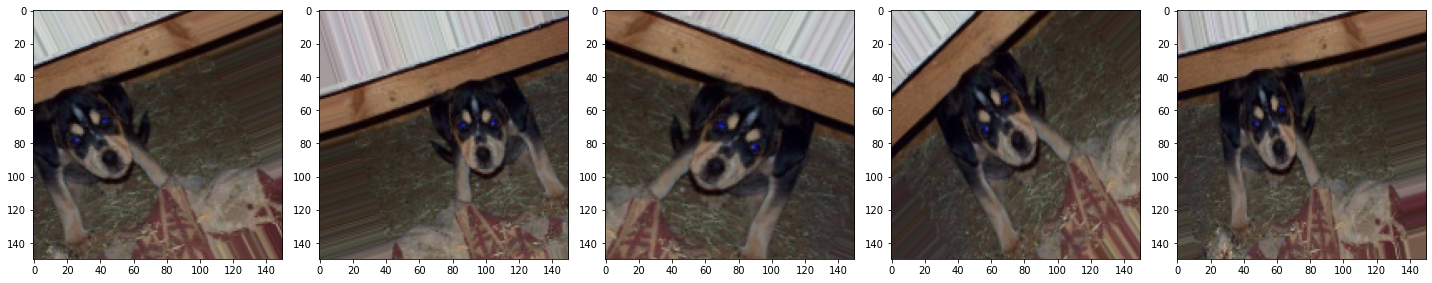

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Генератор проверочных данных
Для проверочных данных, скорей всего, нет смысла делать все-все аугментации, достаточно самых распространенных или вообще без них. Ведь все-таки задача проверки узнать, насколько хороша модель на реальных данных. Здесь мы только приведем значения пикселей к 0...1, поделив их на 255.

In [ ]:
# генератор проверочных данных
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Создание модели классификации

Это будет обычная сеть с четырьмя сверточными слоями, слоями макспулинга.

Добавим и слой Dropout перед полносвязным с вероятностью отброса 0.5.

Полносвязный слой с 512 нейронами и `relu` активацией. Два выхода (по числу классов) с функцией активации `softmax`.

Вы можете модифицировать сеть по своему усмотрению.

In [ ]:
model = tf.keras.models.Sequential([ # сеть из последовательных слоев, перечисляем:
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)), # сверточный
    tf.keras.layers.MaxPooling2D(2, 2), # пулинг

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), # сверточный
    tf.keras.layers.MaxPooling2D(2,2), # пулинг

    tf.keras.layers.Flatten(), # вытягиваем все в вектор

    tf.keras.layers.Dropout(0.5), # регуляризация дропаут
    tf.keras.layers.Dense(512, activation='relu'), # полносвязный

    tf.keras.layers.Dense(2) # выходной
])

### Параметры модели

Используем метод обучения  `adam`. Функция ошибки `sparse_categorical_crossentropy`.
Наблюдаем за аккуратностью accuracy классификации (метрика).

In [ ]:
model.compile(optimizer='adam', # метод обучения
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # функция ошибки
              metrics=['accuracy']) # метрика

In [ ]:
model.summary() # информация о модели

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

### Обучение модели

Наши данные теперь создаются генератором, в старых версиях tensorflow нужно использовать метод  `fit_generator` вместо привычного `fit`, в этой не надо.

In [ ]:
# Сохраним необученную модель
model.save_weights('my_model')

In [ ]:
epochs=100 # количество эпох
# обучаем (~15 минут)
history = model.fit(
    train_data_gen, # генератор обучающих данных
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), # количество примеров на одну эпоху
    epochs=epochs, # количество эпох
    validation_data=val_data_gen, # генератор проверочных данных
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))) # как часто проводить проверку
)

Epoch 1/100
20/20 [==============================] - 31s 811ms/step - loss: 0.7345 - accuracy: 0.4950 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 16s 813ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6920 - val_accuracy: 0.5310
Epoch 3/100
20/20 [==============================] - 16s 816ms/step - loss: 0.6911 - accuracy: 0.5290 - val_loss: 0.6896 - val_accuracy: 0.5070
Epoch 4/100
20/20 [==============================] - 16s 820ms/step - loss: 0.6871 - accuracy: 0.5285 - val_loss: 0.6623 - val_accuracy: 0.5950
Epoch 5/100
20/20 [==============================] - 16s 809ms/step - loss: 0.6747 - accuracy: 0.5670 - val_loss: 0.6760 - val_accuracy: 0.5180
Epoch 6/100
20/20 [==============================] - 16s 802ms/step - loss: 0.6690 - accuracy: 0.5795 - val_loss: 0.6645 - val_accuracy: 0.5610
Epoch 7/100
20/20 [==============================] - 16s 808ms/step - loss: 0.6675 - accuracy: 0.5725 - val_loss: 0.6417 - val_accuracy:

### Визуализация результатов

In [ ]:
def visualize_my_model(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


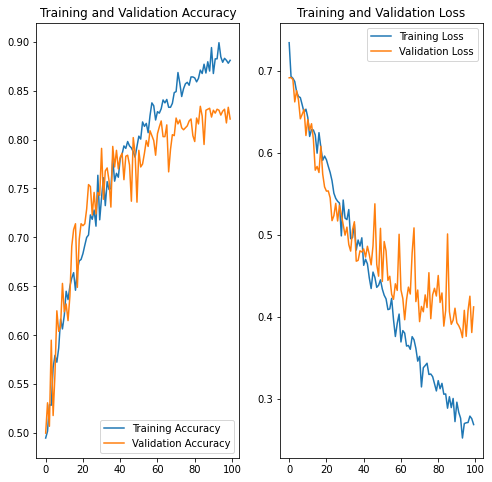

In [ ]:
visualize_my_model(history)

Получилось довольно не плохо (но, конечно, не идеально) 82% аккуратности на проверке, 88% на обучении.

Сделайте то же самое, но уберите все аугментации (кроме не случайных) и сравните.


# Классификация кошек и собак без аугментаци данных

In [ ]:
# Без аугментаций
image_gen_train = ImageDataGenerator(
      rescale=1./255, # изменение величины пикселей, это по сути приведет к диапозону 0...1
      fill_mode='nearest') # как заполнять пустые пиксели

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, # размер пакета
                                                     directory=train_dir, #директория с данными
                                                     shuffle=True, # перемешивать ли
                                                     target_size=(IMG_SHAPE,IMG_SHAPE), # размер результата
                                                     class_mode='binary') # способ задания меток

Found 2000 images belonging to 2 classes.


In [ ]:
# Восстановим необученную модель
model.load_weights('my_model')

In [ ]:
epochs=100 # количество эпох
# обучаем (~15 минут)
history = model.fit(
    train_data_gen, # генератор обучающих данных
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))), # количество примеров на одну эпоху
    epochs=epochs, # количество эпох
    validation_data=val_data_gen, # генератор проверочных данных
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))) # как часто проводить проверку
)

Epoch 1/100
20/20 [==============================] - 8s 426ms/step - loss: 0.8186 - accuracy: 0.5185 - val_loss: 0.6966 - val_accuracy: 0.5000
Epoch 2/100
20/20 [==============================] - 8s 418ms/step - loss: 0.6938 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/100
20/20 [==============================] - 8s 410ms/step - loss: 0.6938 - accuracy: 0.5085 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 4/100
20/20 [==============================] - 8s 411ms/step - loss: 0.6926 - accuracy: 0.5105 - val_loss: 0.6914 - val_accuracy: 0.5080
Epoch 5/100
20/20 [==============================] - 8s 415ms/step - loss: 0.6947 - accuracy: 0.5240 - val_loss: 0.6908 - val_accuracy: 0.5200
Epoch 6/100
20/20 [==============================] - 8s 413ms/step - loss: 0.6940 - accuracy: 0.5060 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 7/100
20/20 [==============================] - 8s 417ms/step - loss: 0.6884 - accuracy: 0.4965 - val_loss: 0.6862 - val_accuracy: 0.5520

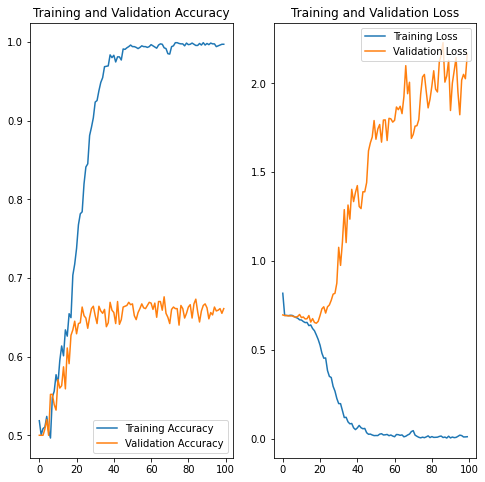

In [ ]:
# Смотрим на результат
visualize_my_model(history)

У меня получилось 77% аккуратности на проверке (еще и возрастает), 99% на обучении! Явно проблема сильного  переобучения.  Но зато обучение было в два раза быстрее.

Итак, аугментация приносит пользу в борьбе с переобучением.

# Ссылки

Использованы и адаптированы материалы

https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/exploring_data_augmentation_keras.ipynb#scrollTo=2KpA-QvpPCqi

https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb#scrollTo=tGNKLa_YVrXR

https://colab.research.google.com/github/dufourpascal/stepupai/blob/master/tutorials/data_augmentation/custom_data_augmentation_keras.ipynb


